In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import zipfile
import os
import time

zip_file = "/root/videos.zip"
z = zipfile.ZipFile(zip_file, "r")
z.extractall("/root/videos")

print(os.listdir())

['colab_pipeline.ipynb', 'dataset_info.ipynb', 'mp4_to_avi.ipynb', 'pileline.ipynb']


In [ ]:
!pip install "git+https://github.com/facebookresearch/pytorchvideo.git"

In [4]:
!pip install wandb accelerate transformers imageio evaluate # pytorchvideo

In [ ]:
!huggingface-cli login

In [1]:
import os
import pytorchvideo.data
import torch
from torch.utils.data import DataLoader
from transformers import VideoMAEImageProcessor, VideoMAEForVideoClassification
from transformers import TrainingArguments, Trainer
import evaluate

from pytorchvideo.transforms import (
    ApplyTransformToKey,
    Normalize,
    RandomShortSideScale,
    RemoveKey,
    ShortSideScale,
    UniformTemporalSubsample,
    MixUp,
)

from torchvision.transforms import v2

from torchvision.transforms import (
    Compose,
    Lambda,
    RandomCrop,
    RandomHorizontalFlip,
    Resize,
)

import imageio
import numpy as np
from IPython.display import Image

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Delete broken samples

In [7]:
import subprocess
import os

def check_video(file_path):
    """ Проверяет видеофайл на повреждения с помощью FFmpeg. """
    try:
        result = subprocess.run(['ffmpeg', '-v', 'error', '-i', file_path, '-f', 'null', '-'], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        return result.stderr
    except Exception as e:
        return str(e)

def scan_directory(directory):
    """ Сканирует директорию на наличие поврежденных видеофайлов. """
    failed_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.mp4'):
                file_path = os.path.join(root, file)
                error = check_video(file_path)
                if error:
                    failed_files.append(file_path)
                    print(f"Поврежденный файл: {file_path}\nОшибка: {error}")
    return failed_files

In [8]:
# Проверяем директории videos/train и videos/val
train_failed = scan_directory('/content/home/myashka/dl_programming_tech/coin_dataset_classification/data/videos/train')

In [ ]:
val_failed = scan_directory('/content/videos/val')

In [7]:
train_damaged_videos = [
    "/content/videos/train/ElectricalAppliance/CSGi2mBh0Os.mp4",
    "/content/videos/train/ElectricalAppliance/TDm3IX_0gLQ.mp4",
    "/content/videos/train/Housework/b9LBMy8_3-E.mp4",
    "/content/videos/train/Vehicle/Y9u-zmH6yz0.mp4",
    "/content/videos/train/Vehicle/3R8KgG-0X_Q.mp4",
    "/content/videos/train/Dish/XMXsVSchsWc.mp4",
    "/content/videos/train/FurnitureandDecoration/8ed8DjTm7VQ.mp4",
    "/content/videos/train/FurnitureandDecoration/fP8zX6UKsRA.mp4",
    "/content/videos/train/FurnitureandDecoration/Ntzsfe0xzF8.mp4",
    "/content/videos/train/LeisureandPerformance/8SWBWxqXulE.mp4",
    "/content/videos/train/LeisureandPerformance/m2TDD-ogwog.mp4",
    "/content/videos/train/LeisureandPerformance/IjwP6hRFaI8.mp4",
    "/content/videos/train/LeisureandPerformance/tpNZUJVo3bQ.mp4",
    "/content/videos/train/LeisureandPerformance/pLlk2ahyNgs.mp4",
    "/content/videos/train/NursingandCare/9O63JaEPrTA.mp4",
    "/content/videos/train/Gadgets/ut5HYK4g7KA.mp4",
    "/content/videos/train/Gadgets/l8JneKWvYrU.mp4",
    "/content/videos/train/Gadgets/iD0QvQyhGSA.mp4",
    "/content/videos/train/Gadgets/48pfFiR6ras.mp4",
    "/content/videos/train/Sport/wPGxAEkjBmY.mp4",
    "/content/videos/train/Sport/NLy71UrHElw.mp4",
    "/content/videos/train/Sport/kJ1JSGamJD4.mp4",
    "/content/videos/train/Sport/grptW7-6Jdg.mp4"
]

val_damaged_videos = ["/content/videos/val/Housework/2ESPauwYUnQ.mp4",
                      "/content/videos/val/ScienceandCraft/plqx50x8ft4.mp4",
                      "/content/videos/val/LeisureandPerformance/dkDUFlHIh64.mp4",
                      "/content/videos/val/NursingandCare/WBC8koF-oDQ.mp4",
                      "/content/videos/val/Gadgets/s2HN0X5BLrQ.mp4",
                      "/content/videos/val/DrinkandSnack/GamLf68iz0E.mp4",
                      "/content/videos/val/Sport/DhuidqjsWmo.mp4",
                      "/content/videos/val/Sport/jhYtXcbWPgY.mp4"
                      ]



In [ ]:
def delete_files(paths):
  for video_path in paths:
      if os.path.exists(video_path):
          os.remove(video_path)
          print(f"Удален файл: {video_path}")
      else:
          print(f"Файл не найден: {video_path}")

delete_files(train_damaged_videos)
delete_files(val_damaged_videos)

In [13]:
# Подсчет оставшихся видео в каждой категории
category_counts = {}

train_dir = '/content/videos/train'
for category in os.listdir(train_dir):
    category_path = os.path.join(train_dir, category)
    if os.path.isdir(category_path):
        videos = [video for video in os.listdir(category_path) if video.endswith('.mp4')]
        category_counts[category] = len(videos)

# Вывод количества видео по категориям
for category, count in category_counts.items():
    print(f"{category}: {count} видео")


Vehicle: 73 видео
ElectricalAppliance: 70 видео
Sport: 85 видео
Dish: 70 видео
ScienceandCraft: 37 видео
Gadgets: 99 видео
Housework: 80 видео
PetsandFruit: 28 видео
DrinkandSnack: 34 видео
NursingandCare: 69 видео
FurnitureandDecoration: 45 видео
LeisureandPerformance: 75 видео


In [14]:
# Подсчет оставшихся видео в каждой категории
category_counts = {}

train_dir = '/content/videos/val'
for category in os.listdir(train_dir):
    category_path = os.path.join(train_dir, category)
    if os.path.isdir(category_path):
        videos = [video for video in os.listdir(category_path) if video.endswith('.mp4')]
        category_counts[category] = len(videos)

# Вывод количества видео по категориям
for category, count in category_counts.items():
    print(f"{category}: {count} видео")


Vehicle: 31 видео
ElectricalAppliance: 13 видео
Sport: 18 видео
Dish: 20 видео
ScienceandCraft: 16 видео
Gadgets: 36 видео
Housework: 28 видео
PetsandFruit: 13 видео
DrinkandSnack: 13 видео
NursingandCare: 22 видео
FurnitureandDecoration: 11 видео
LeisureandPerformance: 24 видео


## Train Pipeline starting

In [2]:
class_labels = sorted(os.listdir("/root/videos/home/myashka/dl_programming_tech/coin_dataset_classification/data/videos/train"))
label2id = {label: i for i, label in enumerate(class_labels)}
id2label = {i: label for label, i in label2id.items()}

print(f"Unique classes {len(list(label2id.keys()))}: {list(label2id.keys())}.")

Unique classes 12: ['Dish', 'DrinkandSnack', 'ElectricalAppliance', 'FurnitureandDecoration', 'Gadgets', 'Housework', 'LeisureandPerformance', 'NursingandCare', 'PetsandFruit', 'ScienceandCraft', 'Sport', 'Vehicle'].


In [3]:
device_map = {"": int(os.environ.get("LOCAL_RANK") or 0)}
device_map

{'': 0}

In [4]:
from transformers import VideoMAEConfig

In [5]:
model_ckpt = "MCG-NJU/videomae-base"
config = VideoMAEConfig(image_size=224,
                        label2id=label2id,
                        id2label=id2label,
                        ignore_mismatched_sizes=True)
image_processor = VideoMAEImageProcessor.from_pretrained(model_ckpt, config=config)

model = VideoMAEForVideoClassification.from_pretrained(
    model_ckpt,
    config=config,
    # torch_dtype=torch.float16,
    device_map=device_map,
)

Some weights of VideoMAEForVideoClassification were not initialized from the model checkpoint at MCG-NJU/videomae-base and are newly initialized: ['fc_norm.bias', 'classifier.bias', 'fc_norm.weight', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
# image_processor.size['shortest_edge'] = 112
# model.config.image_size = 112

In [7]:
mean = image_processor.image_mean
std = image_processor.image_std
print(f"Mean: {mean}\nStd: {std}")
if "shortest_edge" in image_processor.size:
    height = width = image_processor.size["shortest_edge"]
else:
    height = image_processor.size["height"]
    width = image_processor.size["width"]
resize_to = (height, width)
print(f"Resize to {resize_to}")

num_frames_to_sample = model.config.num_frames
sample_rate = 4
fps = 30
clip_duration = num_frames_to_sample * sample_rate / fps
print(f"Num frames to sample: {num_frames_to_sample}")
print(f"Sample rate: {sample_rate}")
print(f"Duration: {clip_duration} sec")

Mean: [0.485, 0.456, 0.406]
Std: [0.229, 0.224, 0.225]
Resize to (224, 224)
Num frames to sample: 16
Sample rate: 4
Duration: 2.1333333333333333 sec


In [8]:
train_transform = v2.Compose(
    [
        ApplyTransformToKey(
            key="video",
            transform=v2.Compose(
                [
                    UniformTemporalSubsample(num_frames_to_sample),
                    v2.Lambda(lambda x: x / 255.0),
                    Normalize(mean, std),
                    RandomShortSideScale(min_size=224, max_size=320),
                    v2.RandomCrop(resize_to),
                    v2.RandomHorizontalFlip(p=0.5),
                ]
            ),
        ),
    ]
)

val_transform = v2.Compose(
    [
        ApplyTransformToKey(
            key="video",
            transform=v2.Compose(
                [
                    UniformTemporalSubsample(num_frames_to_sample),
                    v2.Lambda(lambda x: x / 255.0),
                    Normalize(mean, std),
                    v2.Resize(resize_to),
                ]
            ),
        )
    ]
)

In [9]:
dataset_root_path = "/root/videos/home/myashka/dl_programming_tech/coin_dataset_classification/data/videos/"
train_dataset = pytorchvideo.data.Ucf101(
    data_path=os.path.join(dataset_root_path, "train"),
    clip_sampler=pytorchvideo.data.make_clip_sampler("random", clip_duration),
    decode_audio=False,
    transform=train_transform,
)

val_dataset = pytorchvideo.data.Ucf101(
    data_path=os.path.join(dataset_root_path, "val"),
    clip_sampler=pytorchvideo.data.make_clip_sampler("random", clip_duration),
    decode_audio=False,
    transform=val_transform,
)

In [10]:
print(train_dataset.num_videos, val_dataset.num_videos)
print(f'Test data: {round(val_dataset.num_videos/(train_dataset.num_videos+val_dataset.num_videos)*100, 2)}%')

787 253
Test data: 24.33%


In [11]:
def unnormalize_img(img):
    """Un-normalizes the image pixels."""
    img = (img * std) + mean
    img = (img * 255).astype("uint8")
    return img.clip(0, 255)

def create_gif(video_tensor, filename="sample.gif"):
    """Prepares a GIF from a video tensor.

    The video tensor is expected to have the following shape:
    (num_frames, num_channels, height, width).
    """
    frames = []
    for video_frame in video_tensor:
        frame_unnormalized = unnormalize_img(video_frame.permute(1, 2, 0).numpy())
        frames.append(frame_unnormalized)
    kargs = {"duration": 0.25}
    imageio.mimsave(filename, frames, "GIF", **kargs)
    return filename

def display_gif(video_tensor, gif_name="sample.gif"):
    """Prepares and displays a GIF from a video tensor."""
    video_tensor = video_tensor.permute(1, 0, 2, 3)
    gif_filename = create_gif(video_tensor, gif_name)
    return Image(filename=gif_filename)

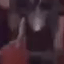

In [11]:
sample_video = next(train_dataset)
video_tensor = sample_video["video"]
display_gif(video_tensor)

In [12]:
# mix_up = MixUp(0.7, num_classes=12)
def collate_fn(examples):
    pixel_values_list = [example["video"].permute(1, 0, 2, 3) for example in examples]
    labels_list = [example["label"] for example in examples]

    pixel_values = torch.stack(pixel_values_list)
    labels = torch.tensor(labels_list)

    return {"pixel_values": pixel_values, "labels": labels}
    # pixel_values = torch.stack(
    #     [example["video"] for example in examples]
    # )
    # labels = torch.tensor([example["label"] for example in examples])
    # pixel_values, labels = mix_up(pixel_values, labels)
    # # permute to (num_frames, num_channels, height, width)
    # pixel_values = torch.stack(
    #     [pixel_value.permute(1, 0, 2, 3) for pixel_value in pixel_values]
    # )
    # labels = torch.argmax(labels, axis=1)
    # return {"pixel_values": pixel_values, "labels": labels}

In [13]:
f1_metric = evaluate.load("f1")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")
accuracy_metric = evaluate.load("accuracy")

In [14]:
def compute_metrics(eval_pred):
    preds = np.argmax(eval_pred.predictions, axis=1)
    labels = eval_pred.label_ids
    results = {}
    results.update(f1_metric.compute(predictions=preds, references = labels, average="micro"))
    results.update(precision_metric.compute(predictions=preds, references = labels, average="micro"))
    results.update(recall_metric.compute(predictions=preds, references = labels, average="micro"))
    results.update(accuracy_metric.compute(predictions=preds, references = labels))
    return results

In [15]:
os.environ["WANDB_PROJECT"] = "ITMO_Video_lab"
os.environ["WANDB_LOG_MODEL"] = "checkpoint"

In [16]:
# for param in model.parameters():
#     param.requires_grad = False

# for param in model.classifier.parameters():
#     param.requires_grad = True
# for param in model.videomae.encoder.layer[-1].parameters():
#     param.requires_grad = True

In [17]:
# model.classifier = model.classifier.to(dtype=torch.float32)
# model.videomae.encoder.layer[-1] = model.videomae.encoder.layer[-1].to(dtype=torch.float32)
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)

videomae.embeddings.patch_embeddings.projection.weight
videomae.embeddings.patch_embeddings.projection.bias
videomae.encoder.layer.0.attention.attention.q_bias
videomae.encoder.layer.0.attention.attention.v_bias
videomae.encoder.layer.0.attention.attention.query.weight
videomae.encoder.layer.0.attention.attention.key.weight
videomae.encoder.layer.0.attention.attention.value.weight
videomae.encoder.layer.0.attention.output.dense.weight
videomae.encoder.layer.0.attention.output.dense.bias
videomae.encoder.layer.0.intermediate.dense.weight
videomae.encoder.layer.0.intermediate.dense.bias
videomae.encoder.layer.0.output.dense.weight
videomae.encoder.layer.0.output.dense.bias
videomae.encoder.layer.0.layernorm_before.weight
videomae.encoder.layer.0.layernorm_before.bias
videomae.encoder.layer.0.layernorm_after.weight
videomae.encoder.layer.0.layernorm_after.bias
videomae.encoder.layer.1.attention.attention.q_bias
videomae.encoder.layer.1.attention.attention.v_bias
videomae.encoder.layer.1.a

In [17]:
model.enable_input_require_grads()

In [18]:
model_name = model_ckpt.split("/")[-1]
new_model_name = f"{model_name}-finetuned-coin_domains-112"
num_epochs = 15
batch_size = 32

args = TrainingArguments(
    new_model_name,
    remove_unused_columns=False,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    max_steps=(train_dataset.num_videos // batch_size) * num_epochs,
    seed=42,
    dataloader_num_workers=10,

    learning_rate=5e-5,
    weight_decay=0.05,
    max_grad_norm=1,
    # optim="adafactor",

    lr_scheduler_type="cosine",
    # warmup_ratio=0.02,

    fp16=True, # torch.float16 wieghts
    gradient_checkpointing=False,
    # gradient_accumulation_steps: 1

    # evaluation_strategy="no",
    eval_steps=train_dataset.num_videos // batch_size * 5,
    evaluation_strategy="steps",

    save_strategy="steps",
    save_steps=train_dataset.num_videos // batch_size *5,

    # save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    save_total_limit=2,
    hub_model_id='Myashka/videomae-base-coin-domains-no_mixup-112',
    push_to_hub=True,

    logging_steps=1,
    report_to='wandb',
    run_name="train-videomae-domains-lr5e_5-no_mixup-bs_128-rnd_val"
)

In [19]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

In [20]:
model.gradient_checkpointing_enable()

In [21]:
import sys
if torch.__version__ >= "2" and sys.platform != "win32":
    model = torch.compile(model)

In [ ]:
train_results = trainer.train()

In [22]:
train_results = trainer.train()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Currently logged in as: myashka. Use `wandb login --relogin` to force relogin


/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy
24,2.087000,2.260927,0.268775,0.268775,0.268775,0.268775
48,2.031000,2.005624,0.339921,0.339921,0.339921,0.339921
72,1.876100,1.848167,0.367589,0.367589,0.367589,0.367589
96,1.617100,1.762735,0.387352,0.387352,0.387352,0.387352
120,1.251500,1.817730,0.418972,0.418972,0.418972,0.418972
144,1.525800,1.649473,0.430830,0.430830,0.430830,0.430830
168,1.091800,1.747039,0.434783,0.434783,0.434783,0.434783
192,1.142900,1.719501,0.442688,0.442688,0.442688,0.442688
216,0.954500,1.528909,0.482213,0.482213,0.482213,0.482213
240,0.704300,1.521585,0.498024,0.498024,0.498024,0.498024


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th